# An Examination of Bias and Fairness in Data Science Job Change Predictor

## Authors: Claire Saint-Donat, Xiangyue Wang

For our final project, we wish to examine an Automated Decision System (ADS), developed by the Kaggle user Josh, that predicts whether data scientists will seek new jobs. Using a set of features about a given data scientist, the ADS categorizes them as either “job seeker” or “non-job seeker”. The ADS, published on Kaggle, consists of data-preprocessing, data exploration, and model-fitting that utilizes SVM, decision trees, random forests, logistic regression, and KNN. Our aim is to design a nutritional label for the ADS that examines the bias in the data, the processing, and one ML model used in this ADS.

## Set Up & Data Loading

In [1]:
## Set up environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.ticker as mtick
import seaborn as sns
from pandas_profiling import ProfileReport

In [2]:
aug_train = pd.read_csv('aug_train.csv')
display(aug_train.head())
print(aug_train.shape)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


(19158, 14)


In [3]:
ProfileReport(aug_train, minimal=False).to_file(output_file="output_min.html")

## Explore Data Types/Missing Values

In [4]:
aug_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [5]:
aug_train.isnull().sum()/aug_train.shape[0]

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [6]:
aug_train.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [7]:
protected_attributes = ['gender', 'city_development_index', 'experience', 'target']

## Exploratory Data Analysis
The purpose of the code in this section is to evaluate the distributions of each of the variables, understand the nature of missing values in the dataset.

As a secondary goal, we will explore whether there is an association between values being missing a protected attribute or the target variable.

In [8]:
aug_train.isnull().mean()

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [9]:
aug_train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [10]:
aug_train.company_type.value_counts()

Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64

In [11]:
# Add orders to our variables for the sake of visualization
# Orders

ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['no_enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
#exp_yrs_order_2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
size_order = ['0','<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other']
company_order = ['Pvt Ltd','Unknown','Funded Startup','Public Sector','Early Stage Startup','NGO','Other']


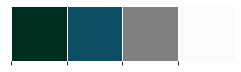

In [12]:
sns.palplot(['#002d1d','#0e4f66','gray','#fbfbfb'])

In [13]:
aug_train.gender.value_counts()

Male      13221
Female     1238
Other       191
Name: gender, dtype: int64

In [ ]:
x=aug_train.groupby(['target'])['target'].count()
y=len(aug_train)
r=((x/y)).round(2)
ratio = pd.DataFrame(r).T


fig, ax = plt.subplots(1,1,figsize=(6.5, 2),dpi=150)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color) 

ax.barh(ratio.index, ratio[1.0], color='#0e4f66', alpha=0.9, ec=background_color, label='Job-Seeker')
ax.barh(ratio.index, ratio[0.0], left=ratio[1.0], color='gray', alpha=0.9,ec=background_color, label='Non Job-Seeker')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.legend().set_visible(False)
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[1.0][i]*100)}%", xy=(ratio[1.0][i]/2, i),va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("Job-Seeker", xy=(ratio[1.0][i]/2, -0.25),va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',color='white')
    
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[0.0][i]*100)}%", xy=(ratio[1.0][i]+ratio[0.0][i]/2, i),va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("Non Job-Seeker", xy=(ratio[1.0][i]+ratio[0.0][i]/2, -0.25),va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',color='white')


fig.text(0.125,1.1,'How many are looking for a new role?', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.915,'We see an imbalanced dataset;\nmost people are not job-seeking',fontfamily='serif',fontsize=12)  


plt.show()

We now create plots that take advantage of GridSpec and plot multiple plots in a highly-customizable fashion.

In [14]:
aug_train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [15]:
aug_train.nunique()

enrollee_id               19158
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   22
company_size                  8
company_type                  6
last_new_job                  6
training_hours              241
target                        2
dtype: int64

In [16]:
aug_train.gender.value_counts(normalize = True, dropna=False)

Male      0.690103
NaN       0.235306
Female    0.064621
Other     0.009970
Name: gender, dtype: float64

In [ ]:
background_color = "#fbfbfb"

fig, ax = plt.subplots(figsize=(22,15), dpi=150)

fig.patch.set_facecolor(background_color)


# Let's start with all the low-cardinality categorical variables
# With cardinality <= 5, we do vertical bar charts

train = pd.DataFrame(aug_train["gender"].value_counts(dropna=False))
train["Percentage"] = train["gender"].apply(lambda x: x/sum(train["gender"])*100)

x = np.arange(len(train))

ax.text(-0.6, 76, 'Gender', fontsize=28, fontweight='bold', fontfamily='serif', color="#323232")
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax.bar(x, height=train["Percentage"], zorder=3, color="gray", width=0.4)
ax.set_xticks(x + 0.4 / 2)

ax.set_xticklabels(['Male','Not Provided','Female','Other'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(mtick.MultipleLocator(10))


plt.rcParams.update({'font.size': 22})
plt.show()

# With cardinatlity >5, we do horizotal bars

Text(0, 0.5, 'GDP Per Capita')

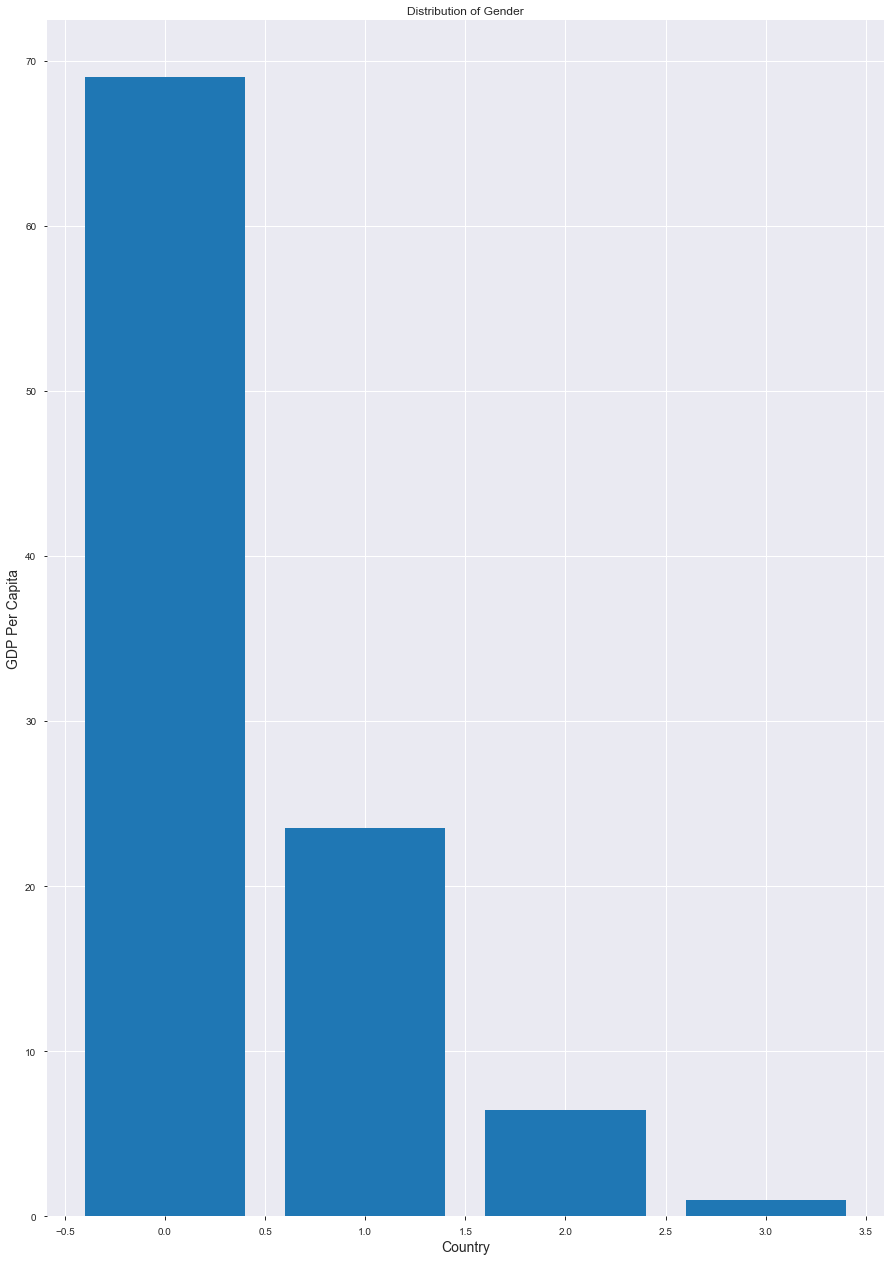

In [17]:
fig, ax = plt.subplots(figsize=(15,22))

train = pd.DataFrame(aug_train["gender"].value_counts(dropna=False))
train["Percentage"] = train["gender"].apply(lambda x: x/sum(train["gender"])*100)
x = np.arange(len(train))
ax.bar(x, train.Percentage)
plt.title('Distribution of Gender')
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Percent of the Data', fontsize=14)
plt.show()

## Implementation and Validation
Present your understanding of the code that implements this ADS. Describe data cleaning and any other pre-processing.  Give high-level information about the implementation of the system. How wan the ADS validated? How do we know that it meets its stated goal(s)?

In [ ]:
## To keep the raw data and the imputed data for the ADS separate,
## we create an alias for our data

train_df = aug_train

In [ ]:
## mimic the data cleaning steps taken in the ADS
train_df['last_new_job'] = train_df['last_new_job'].apply(lambda x: 'Never' if x == 'never' else x) #just reads nicer
train_df['enrolled_university'][train_df['enrolled_university'] == 'no_enrollment'] = 'No Enrollment' #just reads nicer
train_df['company_size'] = train_df['company_size'].apply(lambda x: '10-49' if x == '10/49' else x) #diff replacement method

train_df['experience'] = train_df['experience'].apply(lambda x: '0' if x == '<1' else x)
train_df['experience'] = train_df['experience'].apply(lambda x: '20' if x == '>20' else x)

train_df['company_size'].fillna('0',inplace=True)
train_df['company_type'].fillna('Unknown',inplace=True)
train_df['major_discipline'].fillna('Unknown',inplace=True)
train_df['gender'].fillna('Not provided',inplace=True)

In [ ]:
## Now look at the distribution of missing values and how it's different
train_df.isnull().sum()/train_df.shape[0]

In [ ]:
## Now we drop the remainder of the missing values
train_df.dropna(inplace=True)
print(train_df.shape)
print(train_df.isna().sum()/len(train_df)

In [ ]:
# Converting objects to integers
train_df['experience'] = train_df['experience'].astype(str).astype(int)

train_df['training_hours'] = train_df['training_hours'].astype(str).astype(int)

In [ ]:
# Add orders to our variables for the sake of visualization
# Orders

ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
exp_yrs_order_2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']
company_order = ['Pvt Ltd','Unknown','Funded Startup','Public Sector','Early Stage Startup','NGO','Other']
